# EE 467 Lab 4: Autoencoder and Clustering

In this lab, we will continue to learn two classes of unsupervised machine learning algorithms-dimensionality reduction and clustering. These algorithms can help us figure out previously unknown patterns in the features without any kind of labels. We will apply these algorithms to the KDD Cup 1999 network intrusion dataset and visualize their results. These results may reflect differences in the characteristics of malicious and normal network connections from an alternative perspective.

## Dataset

We will work on the KDD Cup 1999 network intrusion dataset for this lab. The KDD Cup 1999 dataset consists of approximately 4.9 million records of network connections. Here a connection is a sequence of TCP packets starting and ending at some well defined times, during which data flows to and from a source IP address to a target IP address under some well defined protocol. Each connection contains 41 features and is labeled as either normal or an attack, with exactly one specific attack type. The original goal of the contest is to predictive model (i.e. a classifier) capable of distinguishing between malicious connections, called intrusions or attacks, and good normal connections.

Attacks in the KDD Cup 1999 dataset fall into four main categories:

1. DoS: Denial-of-service attacks, e.g. syn flood.
2. R2L: Unauthorized access from a remote machine, e.g. password guessing.
3. U2R: Unauthorized access to local superuser (root) privileges, e.g. privilege escalation through buffer overflow attacks.
4. Probing: surveillance and other probing, e.g. port scanning.

## Prerequisites

Before we begin, install all dependencies needed for this lab:

In [18]:
%pip install torch matplotlib numpy

Then, extract features archive we obtained from the last lab:

## Pre-processing

We have already preformed data pre-processing and dimensionality reduction in the last lab. Here, we load the `StandardScaler`-rescaled features and labels into the memory:

In [19]:
import numpy as np
from sklearn.manifold import TSNE


# Load the three arrays (no t-SNE computation here)
with np.load("./kddcup-1999-pre-processed-data.npz") as data:
    kdd_feat_std = data["kdd_feat_std"]
    kdd_feat_std_tsne = data["kdd_feat_std_tsne"]
    y_std = data["y_std"]

print("kdd_feat_std:", kdd_feat_std.shape)
print("kdd_feat_std_tsne:", kdd_feat_std_tsne.shape)
print("y_std:", y_std.shape)

kdd_feat_std: (24339, 38)
kdd_feat_std_tsne: (24339, 2)
y_std: (24339,)


Like the last lab, we continue to use `visualize_samples` function to plot transformed features in 2D space. Unless specified, we plot normal samples as green dots and malicious samples as orange dots:

Figure(1000x500)


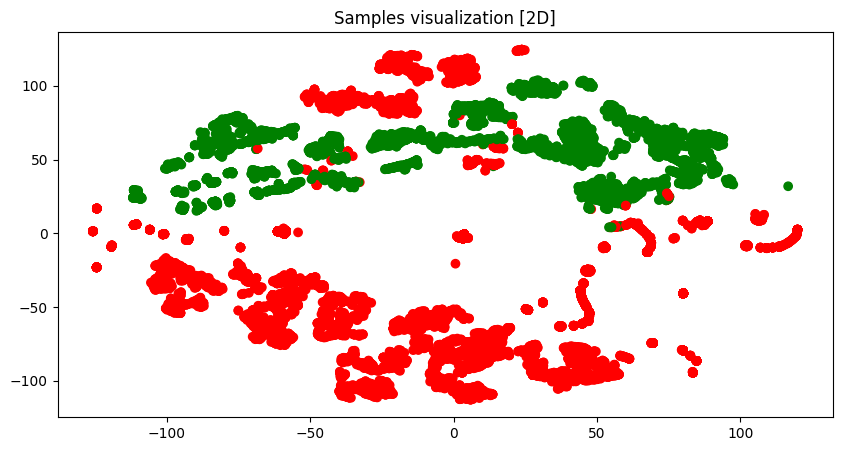

In [20]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_samples(samples, labels, title="Samples visualization", colors=["green", "red"]):
    """ Visualize first three dimensions of samples. """
    # Convert colors to NumPy array
    colors = np.array(colors)
    # Create figure
    fig = plt.figure(figsize=(10, 5))

    # 2D plot
    ax_2d = fig.add_subplot(1, 1, 1)
    ax_2d.set_title(f"{title} [2D]")
    ax_2d.scatter(samples[:, 0], samples[:, 1], c=colors[labels])

    print(fig)

# Visualize `StandardScaler` features (without dimensionality reduction)
visualize_samples(kdd_feat_std_tsne, y_std)

We will also use the following `timeit` function to monitor the training time of machine learning algorithms:

In [21]:
import time
from contextlib import contextmanager

@contextmanager
def timeit(action="Timing"):
    # Record start time
    print(f"{action} started...")
    start_time = time.time()

    # Execute task
    yield

    # Compute and show elapsed time
    elapsed_time = time.time()-start_time
    print(f"{action} completed. Elapsed time: {elapsed_time:.2f}s")

# Test timing function by sleeping for 1 second
with timeit("Testing timing function"):
    time.sleep(1)

Testing timing function started...
Testing timing function completed. Elapsed time: 1.00s


## Autoencoder

We will wrap up the introduction of dimensionality reduction algorithms with autoencoders. An **autoencoder** is a neural network used to learn a compact representation (also called encoding) for a set of data, typically for the purpose of dimensionality reduction. A typical regular autoencoder has a symmetric, five-layer structure shown below:

![autoencoder-structure.png](attachment:autoencoder-structure.png)

Like all other neural networks, the first layer is the **input layer** and the **last layer** is the output layer. For an autoencoder, the input layer and the output layer always have the same shape. We call the first three layers of the autoencoder **encoder network** and the last three layers **decoder network**. Hence, the second layer can be seen as the hidden layer of the encoder network and the fourth layer can be seen as the hidden layer of the decoder network. In practice, the shape of these layers are also made same. The third layer is the **encoder output layer**, and we make it the "bottleneck" of the autoencoder (by reducing its dimensions) so that the neural network learns to "compress" the information of previous encoder layers.

The goal of the autoencoder is to learn to **compress and reconstruct input features**, such that the **reconstruction resembles the original input** as much as possible. This forces the autoencoder to focus on the useful properties of the features and discard the noises. After training, we throw away the decoder network and use the encoder network to transform features. The result of the transformation will have fewer dimensions, yet it still preserves the characteristics and properties of the original, high-dimensional inputs.

From a formal perspective, we define the encoder transformation as $\phi: \mathcal{X} \rightarrow \mathcal{F}$ and the decoder transformation as $\psi: \mathcal{F} \rightarrow \mathcal{X}$, where $\mathcal{X}$ is the original feature space and $\mathcal{F}$ is the target feature space. Then the goal of the autoencoder is to minimize the mean-squared loss between the inputs and reconstructions:

$$
l_{AE} = ||X - \psi(\phi(X))||_2^2
$$

After training, we compute $F = \phi(X)$ to obtain target features with reduced dimensions.

Now, let's build an autoencoder in the following `make_ae_models` function. We have given you the dimensions of input features, hidden layers and the encoder output ("bottleneck") layer, as well as the activation layer type. Your task is to create an encoder and a decoder model, **both with three layers (this is different from the figure above!)**, according to the instructions in comments below. The `autoencoder_loss` function handles computation of the autoencoder (mean-squared) loss.

In [22]:
import torch
from torch import nn
from torch.nn import functional as f
from torch.utils.data import DataLoader

def get_torch_device():
    # Use CUDA (Nvidia/AMD GPU) if available
    if torch.cuda.is_available():
        device = "cuda"
    # Use MPS (Apple Silicon GPU) if available
    elif torch.backends.mps.is_available():
        device = "mps"
    # Fallback to CPU
    else:
        device = "cpu"

    return torch.device(device)


def make_ae_models(
    feat_dims, hidden_dims, bottleneck_dims,
    activation=nn.GELU, dropout_ratio=0., device="cpu"
):
    """Create and return both encoder and decoder PyTorch models."""

    # Define encoder model
    encoder_model = nn.Sequential(
        # [ TODO ]
        # Implement the encoder model to match the reference solution structure:
        #
        #   (*, feat_dims)
        #     -> Linear(feat_dims, hidden_dims)
        #     -> activation()
        #     -> Dropout(dropout_ratio)
        #     -> Linear(hidden_dims, bottleneck_dims)
        #
        # Add the 4 modules below in the correct order:
        nn.Linear(feat_dims, hidden_dims),  # TODO: first Linear
        activation(),  # TODO: activation
        nn.Dropout(dropout_ratio),  # TODO: dropout
        nn.Linear(hidden_dims, bottleneck_dims),  # TODO: bottleneck Linear
    )

    # Define decoder model
    decoder_model = nn.Sequential(
        # [ TODO ]
        # Implement the decoder model to match the reference solution structure:
        #
        #   (*, bottleneck_dims)
        #     -> Linear(bottleneck_dims, hidden_dims)
        #     -> Dropout(dropout_ratio)
        #     -> activation()
        #     -> Linear(hidden_dims, feat_dims)
        #
        # Add the 4 modules below in the correct order:
        nn.Linear(bottleneck_dims, hidden_dims),  # TODO: first Linear
        nn.Dropout(dropout_ratio),  # TODO: dropout
        activation(),  # TODO: activation
        nn.Linear(hidden_dims, feat_dims),  # TODO: output Linear
    )

    # Move models to given PyTorch device
    encoder_model = encoder_model.to(device)
    decoder_model = decoder_model.to(device)

    return encoder_model, decoder_model


def autoencoder_loss(feats, reconstructs, bottlenecks=None, l2_reg_factor=None):
    # Compute mean square error (main) loss between original and reconstructed features
    mse_loss = f.mse_loss(feats, reconstructs)

    # L2 regularization loss for bottleneck features
    if l2_reg_factor:
        l2_reg_loss = bottlenecks.square().sum(-1).mean()
        total_loss = mse_loss+l2_reg_factor*l2_reg_loss
    else:
        total_loss = mse_loss

    return total_loss, mse_loss

We then move on to the implementation of the training loop. This is a simpler version of what we did in lab 3 and homework 2 because no validation is required and thus only a single inner loop needs to be implemented.

In [23]:
from tqdm import tqdm

def train_autoencoder(encoder_model, decoder_model, optimizer, feats, n_epochs, batch_size, l2_reg_factor=0.,
    device=None):
    # Auto-detect PyTorch device from model parameters
    device = device or next(iter(encoder_model.parameters())).device
    # Make data loader for features
    loader = DataLoader(feats, batch_size, shuffle=True)

    for i in range(n_epochs):
        total_loss_epoch = 0.
        mse_loss_epoch = 0.

        print(f"Starting training epoch {i+1}/{n_epochs} ...")

        for feats_batch in tqdm(loader):
            feats_batch = feats.to(device)

            # Forward features through both encoder and decoder,
            # saving bottleneck and reconstructed features in the process
            bottlenecks = encoder_model(feats_batch)
            reconstructs = decoder_model(bottlenecks)
            # Compute autoencoder loss
            total_loss_batch, mse_loss_batch = autoencoder_loss(
                feats_batch, reconstructs, bottlenecks, l2_reg_factor
            )

            # Run an optimizer step
            total_loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Collect statistics
            total_loss_epoch += total_loss_batch.detach().cpu()
            mse_loss_epoch += mse_loss_batch.detach().cpu()

        total_loss_epoch /= len(loader)
        mse_loss_epoch /= len(loader)

        print(f"Training of epoch {i+1}/{n_epochs}: Total loss: {total_loss_epoch.item()}, MSE loss: {mse_loss_epoch.item()}")

Alright, we now have all the components we need to train an autoencoder, and then use it to reduce the dimensionality of our `StandardScaler` features (`kdd_feat_std_tensor`). We will perform these steps, and once we get the bottleneck features from our encoder model, we can visualize them through 2D and 3D plots:

Starting training epoch 1/50 ...


100%|██████████| 96/96 [00:00<00:00, 407.20it/s]


Training of epoch 1/50: Total loss: 0.1492377370595932, MSE loss: 0.1492377370595932
Starting training epoch 2/50 ...


100%|██████████| 96/96 [00:00<00:00, 413.85it/s]


Training of epoch 2/50: Total loss: 0.022339677438139915, MSE loss: 0.022339677438139915
Starting training epoch 3/50 ...


100%|██████████| 96/96 [00:00<00:00, 387.80it/s]


Training of epoch 3/50: Total loss: 0.011170906014740467, MSE loss: 0.011170906014740467
Starting training epoch 4/50 ...


100%|██████████| 96/96 [00:00<00:00, 413.82it/s]


Training of epoch 4/50: Total loss: 0.007456668186932802, MSE loss: 0.007456668186932802
Starting training epoch 5/50 ...


100%|██████████| 96/96 [00:00<00:00, 407.56it/s]


Training of epoch 5/50: Total loss: 0.005360184703022242, MSE loss: 0.005360184703022242
Starting training epoch 6/50 ...


100%|██████████| 96/96 [00:00<00:00, 403.78it/s]


Training of epoch 6/50: Total loss: 0.004369742702692747, MSE loss: 0.004369742702692747
Starting training epoch 7/50 ...


100%|██████████| 96/96 [00:00<00:00, 386.37it/s]


Training of epoch 7/50: Total loss: 0.0037339935079216957, MSE loss: 0.0037339935079216957
Starting training epoch 8/50 ...


100%|██████████| 96/96 [00:00<00:00, 417.38it/s]


Training of epoch 8/50: Total loss: 0.0031576957553625107, MSE loss: 0.0031576957553625107
Starting training epoch 9/50 ...


100%|██████████| 96/96 [00:00<00:00, 406.91it/s]


Training of epoch 9/50: Total loss: 0.0026579995173960924, MSE loss: 0.0026579995173960924
Starting training epoch 10/50 ...


100%|██████████| 96/96 [00:00<00:00, 412.09it/s]


Training of epoch 10/50: Total loss: 0.0022976004984229803, MSE loss: 0.0022976004984229803
Starting training epoch 11/50 ...


100%|██████████| 96/96 [00:00<00:00, 419.70it/s]


Training of epoch 11/50: Total loss: 0.002113089896738529, MSE loss: 0.002113089896738529
Starting training epoch 12/50 ...


100%|██████████| 96/96 [00:00<00:00, 391.07it/s]


Training of epoch 12/50: Total loss: 0.0020115578081458807, MSE loss: 0.0020115578081458807
Starting training epoch 13/50 ...


100%|██████████| 96/96 [00:00<00:00, 417.13it/s]


Training of epoch 13/50: Total loss: 0.0019529814599081874, MSE loss: 0.0019529814599081874
Starting training epoch 14/50 ...


100%|██████████| 96/96 [00:00<00:00, 409.24it/s]


Training of epoch 14/50: Total loss: 0.0018829532200470567, MSE loss: 0.0018829532200470567
Starting training epoch 15/50 ...


100%|██████████| 96/96 [00:00<00:00, 409.64it/s]


Training of epoch 15/50: Total loss: 0.0018305097473785281, MSE loss: 0.0018305097473785281
Starting training epoch 16/50 ...


100%|██████████| 96/96 [00:00<00:00, 395.92it/s]


Training of epoch 16/50: Total loss: 0.0017986736493185163, MSE loss: 0.0017986736493185163
Starting training epoch 17/50 ...


100%|██████████| 96/96 [00:00<00:00, 388.87it/s]


Training of epoch 17/50: Total loss: 0.0017565521411597729, MSE loss: 0.0017565521411597729
Starting training epoch 18/50 ...


100%|██████████| 96/96 [00:00<00:00, 283.72it/s]


Training of epoch 18/50: Total loss: 0.0017499402165412903, MSE loss: 0.0017499402165412903
Starting training epoch 19/50 ...


100%|██████████| 96/96 [00:00<00:00, 312.77it/s]


Training of epoch 19/50: Total loss: 0.0016935748280957341, MSE loss: 0.0016935748280957341
Starting training epoch 20/50 ...


100%|██████████| 96/96 [00:00<00:00, 305.95it/s]


Training of epoch 20/50: Total loss: 0.0016798133729025722, MSE loss: 0.0016798133729025722
Starting training epoch 21/50 ...


100%|██████████| 96/96 [00:00<00:00, 309.74it/s]


Training of epoch 21/50: Total loss: 0.0016649301396682858, MSE loss: 0.0016649301396682858
Starting training epoch 22/50 ...


100%|██████████| 96/96 [00:00<00:00, 281.27it/s]


Training of epoch 22/50: Total loss: 0.001652244827710092, MSE loss: 0.001652244827710092
Starting training epoch 23/50 ...


100%|██████████| 96/96 [00:00<00:00, 318.56it/s]


Training of epoch 23/50: Total loss: 0.0016191814793273807, MSE loss: 0.0016191814793273807
Starting training epoch 24/50 ...


100%|██████████| 96/96 [00:00<00:00, 408.67it/s]


Training of epoch 24/50: Total loss: 0.0016088938573375344, MSE loss: 0.0016088938573375344
Starting training epoch 25/50 ...


100%|██████████| 96/96 [00:00<00:00, 414.03it/s]


Training of epoch 25/50: Total loss: 0.00160110741853714, MSE loss: 0.00160110741853714
Starting training epoch 26/50 ...


100%|██████████| 96/96 [00:00<00:00, 412.65it/s]


Training of epoch 26/50: Total loss: 0.001556296250782907, MSE loss: 0.001556296250782907
Starting training epoch 27/50 ...


100%|██████████| 96/96 [00:00<00:00, 397.30it/s]


Training of epoch 27/50: Total loss: 0.0015573687851428986, MSE loss: 0.0015573687851428986
Starting training epoch 28/50 ...


100%|██████████| 96/96 [00:00<00:00, 403.49it/s]


Training of epoch 28/50: Total loss: 0.0015772095648571849, MSE loss: 0.0015772095648571849
Starting training epoch 29/50 ...


100%|██████████| 96/96 [00:00<00:00, 413.17it/s]


Training of epoch 29/50: Total loss: 0.0015328930458053946, MSE loss: 0.0015328930458053946
Starting training epoch 30/50 ...


100%|██████████| 96/96 [00:00<00:00, 408.84it/s]


Training of epoch 30/50: Total loss: 0.0015260097570717335, MSE loss: 0.0015260097570717335
Starting training epoch 31/50 ...


100%|██████████| 96/96 [00:00<00:00, 400.98it/s]


Training of epoch 31/50: Total loss: 0.001551024615764618, MSE loss: 0.001551024615764618
Starting training epoch 32/50 ...


100%|██████████| 96/96 [00:00<00:00, 411.43it/s]


Training of epoch 32/50: Total loss: 0.0015103364130482078, MSE loss: 0.0015103364130482078
Starting training epoch 33/50 ...


100%|██████████| 96/96 [00:00<00:00, 411.04it/s]


Training of epoch 33/50: Total loss: 0.001509383786469698, MSE loss: 0.001509383786469698
Starting training epoch 34/50 ...


100%|██████████| 96/96 [00:00<00:00, 415.88it/s]


Training of epoch 34/50: Total loss: 0.0014854479813948274, MSE loss: 0.0014854479813948274
Starting training epoch 35/50 ...


100%|██████████| 96/96 [00:00<00:00, 414.77it/s]


Training of epoch 35/50: Total loss: 0.00149733095895499, MSE loss: 0.00149733095895499
Starting training epoch 36/50 ...


100%|██████████| 96/96 [00:00<00:00, 398.73it/s]


Training of epoch 36/50: Total loss: 0.0014860137598589063, MSE loss: 0.0014860137598589063
Starting training epoch 37/50 ...


100%|██████████| 96/96 [00:00<00:00, 399.42it/s]


Training of epoch 37/50: Total loss: 0.0014712567208334804, MSE loss: 0.0014712567208334804
Starting training epoch 38/50 ...


100%|██████████| 96/96 [00:00<00:00, 401.48it/s]


Training of epoch 38/50: Total loss: 0.0014553922228515148, MSE loss: 0.0014553922228515148
Starting training epoch 39/50 ...


100%|██████████| 96/96 [00:00<00:00, 402.83it/s]


Training of epoch 39/50: Total loss: 0.0014430234441533685, MSE loss: 0.0014430234441533685
Starting training epoch 40/50 ...


100%|██████████| 96/96 [00:00<00:00, 396.52it/s]


Training of epoch 40/50: Total loss: 0.0014452161267399788, MSE loss: 0.0014452161267399788
Starting training epoch 41/50 ...


100%|██████████| 96/96 [00:00<00:00, 403.25it/s]


Training of epoch 41/50: Total loss: 0.0014268114464357495, MSE loss: 0.0014268114464357495
Starting training epoch 42/50 ...


100%|██████████| 96/96 [00:00<00:00, 408.91it/s]


Training of epoch 42/50: Total loss: 0.0014333706349134445, MSE loss: 0.0014333706349134445
Starting training epoch 43/50 ...


100%|██████████| 96/96 [00:00<00:00, 394.49it/s]


Training of epoch 43/50: Total loss: 0.0014224289916455746, MSE loss: 0.0014224289916455746
Starting training epoch 44/50 ...


100%|██████████| 96/96 [00:00<00:00, 347.31it/s]


Training of epoch 44/50: Total loss: 0.001388002303428948, MSE loss: 0.001388002303428948
Starting training epoch 45/50 ...


100%|██████████| 96/96 [00:00<00:00, 404.31it/s]


Training of epoch 45/50: Total loss: 0.0013531227596104145, MSE loss: 0.0013531227596104145
Starting training epoch 46/50 ...


100%|██████████| 96/96 [00:00<00:00, 412.59it/s]


Training of epoch 46/50: Total loss: 0.0013378964504227042, MSE loss: 0.0013378964504227042
Starting training epoch 47/50 ...


100%|██████████| 96/96 [00:00<00:00, 407.64it/s]


Training of epoch 47/50: Total loss: 0.0013299989514052868, MSE loss: 0.0013299989514052868
Starting training epoch 48/50 ...


100%|██████████| 96/96 [00:00<00:00, 385.86it/s]


Training of epoch 48/50: Total loss: 0.0012722868705168366, MSE loss: 0.0012722868705168366
Starting training epoch 49/50 ...


100%|██████████| 96/96 [00:00<00:00, 404.65it/s]


Training of epoch 49/50: Total loss: 0.0012331035686656833, MSE loss: 0.0012331035686656833
Starting training epoch 50/50 ...


100%|██████████| 96/96 [00:00<00:00, 403.13it/s]


Training of epoch 50/50: Total loss: 0.0012192601570859551, MSE loss: 0.0012192601570859551
Figure(1000x500)


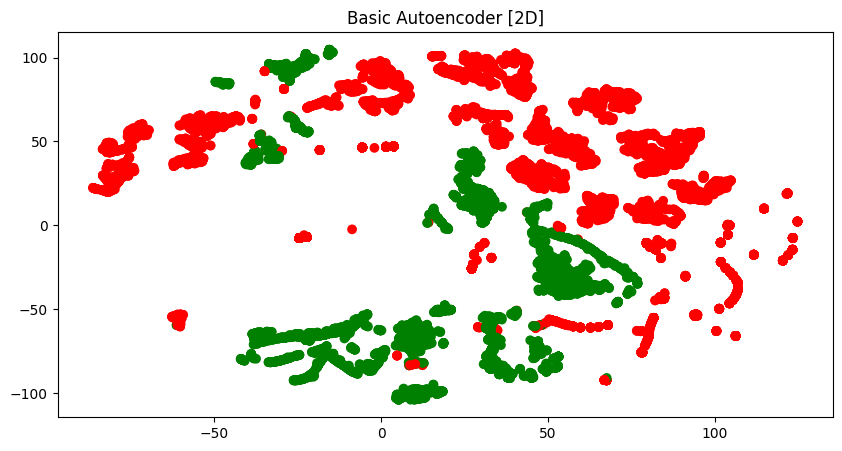

In [24]:
from itertools import chain

from torch.optim import AdamW

# Get preferred PyTorch device
torch_device = get_torch_device()
# Convert `kdd_feat_std` to PyTorch tensor, and put tensor on selected device
kdd_feat_std_tensor = torch.tensor(kdd_feat_std, device=torch_device, dtype=torch.float32)

# Make basic autoencoder models
enc_model_1, dec_model_1 = make_ae_models(
    feat_dims=kdd_feat_std.shape[1],
    hidden_dims=20,
    bottleneck_dims=10,
    device=torch_device
)
# Create optimizer for autoencoder models
optimizer = AdamW(
    chain(enc_model_1.parameters(), dec_model_1.parameters()),
    lr=0.005
)

# Train basic autoencoder models
train_autoencoder(
    enc_model_1, dec_model_1, optimizer, kdd_feat_std_tensor, n_epochs=50, batch_size=256
)
# Perform dimensionality reduction with the encoder
with torch.inference_mode():
    kdd_feat_ae_1 = enc_model_1(kdd_feat_std_tensor)
    kdd_feat_ae_1 = kdd_feat_ae_1.cpu().numpy()

# Run 2D t-SNE on StandardScaler features
autoenc_tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42,
)

kdd_feat_ae_1_tsne = autoenc_tsne.fit_transform(kdd_feat_ae_1)

# Plot basic autoencoder bottleneck features
visualize_samples(kdd_feat_ae_1_tsne, y_std, title="Basic Autoencoder")

Now that we have successfully trained our first autoencoder and transformed `StandardScaler` features to 10D space, we can try a few measures to improve it. First, we are going to **increase the capacity of the hidden layers** of our autoencoder. However, simply enlarging linear layers could make the autoencoder training more likely to overfit. Thus, we will **apply dropout** for the encoder and the decoder each. Another possible mitigation for the overfitting issue is **regularization**, which we will add to the encoder output so that the autoencoder loss becomes:

$$
l_{AE-L2} = ||X - \psi(\phi(X))||_2^2 + \lambda ||\phi(X)||_2^2
$$

To apply these improvements, go back to the `make_ae_models` function, then add [`torch.nn.Dropout`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layers between existing linear and activation layers. The L2 regularization is already implemented in `autoencoder_loss`, and you can enable it by forwarding the `l2_reg_factor` parameter for your `train_autoencoder` function. Finally, play with the hidden layer sizes, dropout ratio and L2 output regularization strength to see how the output features generated by the enhanced autoencoder actually look like.

Starting training epoch 1/50 ...


100%|██████████| 96/96 [00:00<00:00, 359.59it/s]


Training of epoch 1/50: Total loss: 0.12098804116249084, MSE loss: 0.11709561198949814
Starting training epoch 2/50 ...


100%|██████████| 96/96 [00:00<00:00, 364.91it/s]


Training of epoch 2/50: Total loss: 0.04332016408443451, MSE loss: 0.0408509187400341
Starting training epoch 3/50 ...


100%|██████████| 96/96 [00:00<00:00, 186.31it/s]


Training of epoch 3/50: Total loss: 0.03581477329134941, MSE loss: 0.0341290682554245
Starting training epoch 4/50 ...


100%|██████████| 96/96 [00:00<00:00, 224.61it/s]


Training of epoch 4/50: Total loss: 0.03248239681124687, MSE loss: 0.031165555119514465
Starting training epoch 5/50 ...


100%|██████████| 96/96 [00:00<00:00, 352.44it/s]


Training of epoch 5/50: Total loss: 0.030297109857201576, MSE loss: 0.029192252084612846
Starting training epoch 6/50 ...


100%|██████████| 96/96 [00:00<00:00, 347.27it/s]


Training of epoch 6/50: Total loss: 0.028956299647688866, MSE loss: 0.02800123207271099
Starting training epoch 7/50 ...


100%|██████████| 96/96 [00:00<00:00, 359.86it/s]


Training of epoch 7/50: Total loss: 0.0281005147844553, MSE loss: 0.027257410809397697
Starting training epoch 8/50 ...


100%|██████████| 96/96 [00:00<00:00, 367.86it/s]


Training of epoch 8/50: Total loss: 0.02767239511013031, MSE loss: 0.026909956708550453
Starting training epoch 9/50 ...


100%|██████████| 96/96 [00:00<00:00, 360.31it/s]


Training of epoch 9/50: Total loss: 0.027046196162700653, MSE loss: 0.026346666738390923
Starting training epoch 10/50 ...


100%|██████████| 96/96 [00:00<00:00, 340.89it/s]


Training of epoch 10/50: Total loss: 0.026656009256839752, MSE loss: 0.026012105867266655
Starting training epoch 11/50 ...


100%|██████████| 96/96 [00:00<00:00, 355.28it/s]


Training of epoch 11/50: Total loss: 0.026143120601773262, MSE loss: 0.025541232898831367
Starting training epoch 12/50 ...


100%|██████████| 96/96 [00:00<00:00, 356.81it/s]


Training of epoch 12/50: Total loss: 0.02579474449157715, MSE loss: 0.025225942954421043
Starting training epoch 13/50 ...


100%|██████████| 96/96 [00:00<00:00, 360.81it/s]


Training of epoch 13/50: Total loss: 0.025447377935051918, MSE loss: 0.024899380281567574
Starting training epoch 14/50 ...


100%|██████████| 96/96 [00:00<00:00, 344.41it/s]


Training of epoch 14/50: Total loss: 0.02506822533905506, MSE loss: 0.02453978918492794
Starting training epoch 15/50 ...


100%|██████████| 96/96 [00:00<00:00, 356.54it/s]


Training of epoch 15/50: Total loss: 0.02503906935453415, MSE loss: 0.02452816069126129
Starting training epoch 16/50 ...


100%|██████████| 96/96 [00:00<00:00, 361.08it/s]


Training of epoch 16/50: Total loss: 0.024528726935386658, MSE loss: 0.024026134982705116
Starting training epoch 17/50 ...


100%|██████████| 96/96 [00:00<00:00, 359.62it/s]


Training of epoch 17/50: Total loss: 0.024559110403060913, MSE loss: 0.02406705915927887
Starting training epoch 18/50 ...


100%|██████████| 96/96 [00:00<00:00, 337.35it/s]


Training of epoch 18/50: Total loss: 0.0242288988083601, MSE loss: 0.023748919367790222
Starting training epoch 19/50 ...


100%|██████████| 96/96 [00:00<00:00, 359.55it/s]


Training of epoch 19/50: Total loss: 0.024132028222084045, MSE loss: 0.023663178086280823
Starting training epoch 20/50 ...


100%|██████████| 96/96 [00:00<00:00, 283.98it/s]


Training of epoch 20/50: Total loss: 0.024272538721561432, MSE loss: 0.023807793855667114
Starting training epoch 21/50 ...


100%|██████████| 96/96 [00:00<00:00, 266.42it/s]


Training of epoch 21/50: Total loss: 0.023980997502803802, MSE loss: 0.023522155359387398
Starting training epoch 22/50 ...


100%|██████████| 96/96 [00:00<00:00, 267.71it/s]


Training of epoch 22/50: Total loss: 0.023626411333680153, MSE loss: 0.02317202277481556
Starting training epoch 23/50 ...


100%|██████████| 96/96 [00:00<00:00, 288.05it/s]


Training of epoch 23/50: Total loss: 0.02394603192806244, MSE loss: 0.023498525843024254
Starting training epoch 24/50 ...


100%|██████████| 96/96 [00:00<00:00, 253.67it/s]


Training of epoch 24/50: Total loss: 0.023633986711502075, MSE loss: 0.023193323984742165
Starting training epoch 25/50 ...


100%|██████████| 96/96 [00:00<00:00, 249.98it/s]


Training of epoch 25/50: Total loss: 0.023674270138144493, MSE loss: 0.02324143797159195
Starting training epoch 26/50 ...


100%|██████████| 96/96 [00:00<00:00, 360.31it/s]


Training of epoch 26/50: Total loss: 0.023342130705714226, MSE loss: 0.02291363663971424
Starting training epoch 27/50 ...


100%|██████████| 96/96 [00:00<00:00, 332.71it/s]


Training of epoch 27/50: Total loss: 0.02335573546588421, MSE loss: 0.022935880348086357
Starting training epoch 28/50 ...


100%|██████████| 96/96 [00:00<00:00, 362.57it/s]


Training of epoch 28/50: Total loss: 0.023412123322486877, MSE loss: 0.022998109459877014
Starting training epoch 29/50 ...


100%|██████████| 96/96 [00:00<00:00, 343.10it/s]


Training of epoch 29/50: Total loss: 0.023273102939128876, MSE loss: 0.02286338061094284
Starting training epoch 30/50 ...


100%|██████████| 96/96 [00:00<00:00, 359.24it/s]


Training of epoch 30/50: Total loss: 0.0235432181507349, MSE loss: 0.02313808910548687
Starting training epoch 31/50 ...


100%|██████████| 96/96 [00:00<00:00, 351.17it/s]


Training of epoch 31/50: Total loss: 0.02297193743288517, MSE loss: 0.022567713633179665
Starting training epoch 32/50 ...


100%|██████████| 96/96 [00:00<00:00, 364.46it/s]


Training of epoch 32/50: Total loss: 0.023087112233042717, MSE loss: 0.022691994905471802
Starting training epoch 33/50 ...


100%|██████████| 96/96 [00:00<00:00, 362.86it/s]


Training of epoch 33/50: Total loss: 0.02314681001007557, MSE loss: 0.02275613509118557
Starting training epoch 34/50 ...


100%|██████████| 96/96 [00:00<00:00, 360.01it/s]


Training of epoch 34/50: Total loss: 0.022955454885959625, MSE loss: 0.022568022832274437
Starting training epoch 35/50 ...


100%|██████████| 96/96 [00:00<00:00, 344.68it/s]


Training of epoch 35/50: Total loss: 0.022853774949908257, MSE loss: 0.02247186191380024
Starting training epoch 36/50 ...


100%|██████████| 96/96 [00:00<00:00, 358.38it/s]


Training of epoch 36/50: Total loss: 0.02312023751437664, MSE loss: 0.022740744054317474
Starting training epoch 37/50 ...


100%|██████████| 96/96 [00:00<00:00, 363.81it/s]


Training of epoch 37/50: Total loss: 0.022789031267166138, MSE loss: 0.022415010258555412
Starting training epoch 38/50 ...


100%|██████████| 96/96 [00:00<00:00, 354.03it/s]


Training of epoch 38/50: Total loss: 0.02291054092347622, MSE loss: 0.02254013530910015
Starting training epoch 39/50 ...


100%|██████████| 96/96 [00:00<00:00, 325.61it/s]


Training of epoch 39/50: Total loss: 0.022712500765919685, MSE loss: 0.02234473079442978
Starting training epoch 40/50 ...


100%|██████████| 96/96 [00:00<00:00, 366.30it/s]


Training of epoch 40/50: Total loss: 0.02257808856666088, MSE loss: 0.022214313969016075
Starting training epoch 41/50 ...


100%|██████████| 96/96 [00:00<00:00, 361.43it/s]


Training of epoch 41/50: Total loss: 0.02271193079650402, MSE loss: 0.022350890561938286
Starting training epoch 42/50 ...


100%|██████████| 96/96 [00:00<00:00, 347.82it/s]


Training of epoch 42/50: Total loss: 0.022652223706245422, MSE loss: 0.02229524590075016
Starting training epoch 43/50 ...


100%|██████████| 96/96 [00:00<00:00, 364.09it/s]


Training of epoch 43/50: Total loss: 0.022901883348822594, MSE loss: 0.022545302286744118
Starting training epoch 44/50 ...


100%|██████████| 96/96 [00:00<00:00, 359.75it/s]


Training of epoch 44/50: Total loss: 0.022542456164956093, MSE loss: 0.02218761295080185
Starting training epoch 45/50 ...


100%|██████████| 96/96 [00:00<00:00, 345.93it/s]


Training of epoch 45/50: Total loss: 0.02258053608238697, MSE loss: 0.022228794172406197
Starting training epoch 46/50 ...


100%|██████████| 96/96 [00:00<00:00, 333.76it/s]


Training of epoch 46/50: Total loss: 0.022535445168614388, MSE loss: 0.022186629474163055
Starting training epoch 47/50 ...


100%|██████████| 96/96 [00:00<00:00, 353.69it/s]


Training of epoch 47/50: Total loss: 0.022495528683066368, MSE loss: 0.022150015458464622
Starting training epoch 48/50 ...


100%|██████████| 96/96 [00:00<00:00, 358.58it/s]


Training of epoch 48/50: Total loss: 0.02261231280863285, MSE loss: 0.022267578169703484
Starting training epoch 49/50 ...


100%|██████████| 96/96 [00:00<00:00, 356.96it/s]


Training of epoch 49/50: Total loss: 0.022499987855553627, MSE loss: 0.02215643972158432
Starting training epoch 50/50 ...


100%|██████████| 96/96 [00:00<00:00, 337.01it/s]


Training of epoch 50/50: Total loss: 0.02259320579469204, MSE loss: 0.022252192720770836
Figure(1000x500)


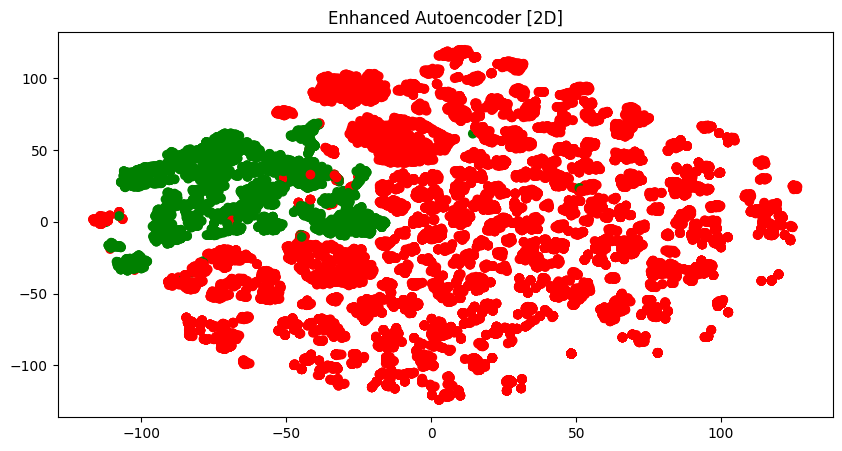

In [28]:
# [ TODO ]
# Make enhanced autoencoder models with the following improvements:
# 1) Increased hidden layer capacity (`hidden_dims=25`)
# 2) Enable dropout to prevent over-fitting (`dropout_ratio=0.1`)
#
# NOTE: Use feat_dims=kdd_feat_std.shape[1] and device=torch_device
enc_model_2, dec_model_2 = make_ae_models(
    feat_dims=kdd_feat_std.shape[1],
    hidden_dims=25,
    bottleneck_dims=10, # Keeping bottleneck_dims as 10, similar to the basic autoencoder
    dropout_ratio=0.1,
    device=torch_device
)


# Create optimizer for autoencoder models (fixed learning rate)
optimizer = AdamW(
    chain(enc_model_2.parameters(), dec_model_2.parameters()),
    lr=0.01
)

# Train enhanced autoencoder models
# Enable L2 regularization of decoder output (bottleneck features) using:
train_autoencoder(
    enc_model_2, dec_model_2, optimizer, kdd_feat_std_tensor,
    n_epochs=50, batch_size=256,
    l2_reg_factor=0.001
)

# Perform dimensionality reduction with the encoder
with torch.inference_mode():
    kdd_feat_ae_2 = enc_model_2(kdd_feat_std_tensor)
    kdd_feat_ae_2 = kdd_feat_ae_2.cpu().numpy()

# [ TODO ]
# Run 2D t-SNE on the *autoencoder bottleneck features* (kdd_feat_ae_2) using:
# - n_components=2
# - perplexity=30
# - learning_rate="auto"
# - init="pca"
#
# Then:
# - fit_transform kdd_feat_ae_2
# - store result in kdd_feat_ae_2_tsne
autoenc_tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42,
)
kdd_feat_ae_2_tsne = autoenc_tsne.fit_transform(kdd_feat_ae_2)

# Plot enhanced autoencoder bottleneck features (2D tsne)
visualize_samples(kdd_feat_ae_2_tsne, y_std, title="Enhanced Autoencoder")

## Clustering

The second part of this lab involves clustering analysis, or simply **clustering**. It is the task of grouping samples into multiple groups (called **clusters**) such that samples within the same group are more similar than samples from different groups. Clustering algorithms are **unsupervised learning** algorithms because grouping is solely based on the features, without the need of any labels, though you will see in the later part of this lab that labels can help evaluate clustering result.

Like the previous lab, a few utility functions are required to compute metrics for clustering result. The first one is `confusion_matrix`, which does exactly the same thing as `sklearn.metrics.confusion_matrix`, except it allows different number of classes in predictions and true labels. This makes it handy for clustering result because the number of clusters may not necessarily equal to the number of true classes.

In [29]:
def confusion_matrix(actuals, preds):
    """ Extension of `sklearn.metrics.confusion_matrix`, suitable for clustering results. """
    # Number of classes of predictions and true labels
    n_classes_actual = max(actuals)+1
    n_classes_pred = max(preds)+1
    # Confusion matrix
    matrix = np.zeros((n_classes_pred, n_classes_actual), dtype=int)

    # Update matrix count for each sample
    for pred, actual in zip(preds, actuals):
        matrix[pred][actual] += 1

    return matrix

The second function computes the overall entropy of clustering result, when the true labels are available. Assume we have $c$ classes and $k$ clusters $\Omega = {\omega_1, \dots, \omega_k}$, the in-cluster entropy for cluster $i$ can be computed by:

$$
H(\omega_i) = -\sum_{j=1}^c \frac{|\omega_{ij}|}{|\omega_i|} \log \frac{|\omega_{ij}|}{|\omega_i|}
$$

where $\omega_{ij}$ represents samples that belong to both cluster $i$ and class $j$. The overall entropy of clustering result, which is the weighted average of in-cluster entropy, can then be computed as:

$$
H(\Omega) = \sum_{i=1}^k \frac{|\omega_i|}{|\Omega|} H(\omega_i)
$$

Later you will see that the overall entropy of clustering result is a good metric to determine the amount of clusters.

In [30]:
# Epsilon for entropy computation
EPSILON = 0.01

def clustering_entropy(conf_matrix):
    """ Compute the entropy of classification result. """
    zero_items = conf_matrix==0
    # Add an epsilon to zero elements in confusion matrix
    if zero_items.any():
        conf_matrix = conf_matrix.astype(float)
        conf_matrix[zero_items] += EPSILON

    # In-cluster sample distributions
    in_cluster_dists = conf_matrix/np.sum(conf_matrix, axis=-1, keepdims=True)
    # Entropy of all clusters
    entropy_clusters = -np.sum(in_cluster_dists*np.log(in_cluster_dists), axis=-1)

    # Proportion of samples of each cluster
    sample_props = np.sum(conf_matrix, axis=-1)/np.sum(conf_matrix)
    # Overall clustering entropy
    return np.sum(sample_props*entropy_clusters)

### K-means (Centroid-based clustering)

Strictly speaking, **K-means clustering** refers to the problem of partitioning sample features in to $k$ clusters, in which each sample belongs to the cluster with the nearest mean (also known as **centroid**). K-means minimizes in-cluster variances (mean squared distance of sample to corresponding cluster centroid) when forming such $k$ clusters. Mathmatically, the loss function of K-means can be written as follows:

$$
l_{K-Means} = \arg \min_S \sum_{i=1}^k \sum_{\mathbf{x} \in S_i} ||\mathbf{x} - \mathbf{\mu}_i||_2^2
$$

where $S$ represents the partition of all samples, $S_i$ represents cluster $i$, $\mu_i$ is the centroid (mean) of all samples within cluster $i$.

K-means itself is an NP-hard problem, meaning it's prohibitive to find the optimal partition. However in almost all cases, near optimal partition yielded by approximation algorithms would be good enough. The most commonly used algorithm to solve K-means problem is **Lloyd's algorithm**. It starts by randomly select $k$ cluster centers, then it alternates between two steps:

* Assignment: assign each sample to the cluster whose current center is the nearest.
* Update: for all samples within each cluster, recompute the center of clustering by setting it to the mean of all member samples.

The algorithm terminates when sample assignments no longer change. Later improvements, such as **K-means++ initialization**, further reduces the convergence time of the naive K-means algorithm.

In the following code cell, we run K-means clustering on raw `StandardScaler` features and t-SNE transformed `StandardScaler` features. Here let's set $k = 4$. We will compute the confusion matrix for both clustering results, then visualize the clustering result for t-SNE transformed `StandardScaler` features as it has only three dimensions:

K-Means (Raw features) started...
K-Means (Raw features) completed. Elapsed time: 0.02s
K-Means (AE-1) started...
K-Means (AE-1) completed. Elapsed time: 0.02s
K-Means (AE-2) started...
K-Means (AE-2) completed. Elapsed time: 0.02s

Confusion matrix of K-means on raw features:
 [[ 4403 14183]
 [   76  4355]
 [  272  1050]] 

Confusion matrix of K-means on autoencoder transformed features (AE-1):
 [[    2 14006]
 [    0  4346]
 [ 1621    38]
 [  213  1018]
 [  448    28]
 [  283    41]
 [ 1482    97]
 [  702    14]] 

Confusion matrix of K-means on autoencoder transformed features (AE-2):
 [[  10 4432]
 [   4 4351]
 [1579   25]
 [   7 1025]
 [1811   34]
 [ 771   16]
 [  11 9577]
 [ 284   35]
 [ 274   93]] 

Figure(1000x500)
Figure(1000x500)


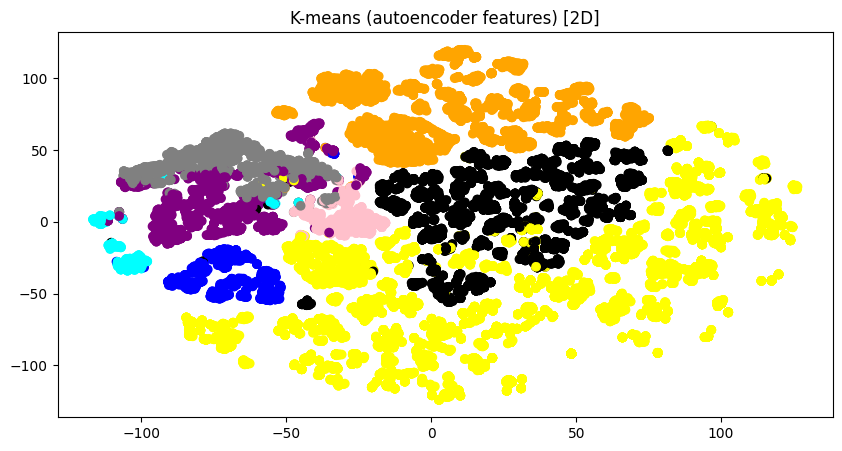

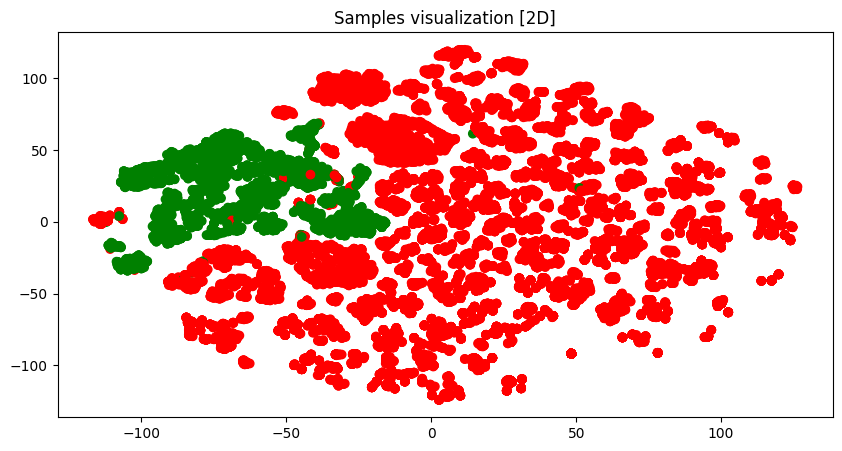

In [31]:
from sklearn.cluster import MiniBatchKMeans

# [ TODO ]
# Perform K-means clustering using MiniBatchKMeans on:
#
# 1) Raw `StandardScaler` features: kdd_feat_std
#    - Use n_clusters=3, n_init="auto"
#    - Store the fitted model in k_means_std
#    - Store predictions in pred_k_means_std
#    - Wrap fit_predict with:  with timeit("K-Means (Raw features)"):
#
# 2) Autoencoder-1 bottleneck features: kdd_feat_ae_1
#    - Use n_clusters=8, n_init="auto"
#    - Store the fitted model in k_means_autoenc1
#    - Store predictions in pred_k_means_autoenc1
#    - Wrap fit_predict with:  with timeit("K-Means (AE-1)"):
#
# 3) Autoencoder-2 bottleneck features: kdd_feat_ae_2
#    - Use n_clusters=9, n_init="auto"
#    - Store the fitted model in k_means_autoenc2
#    - Store predictions in pred_k_means_autoenc2
#
# NOTE:
# - Use fit_predict(...) on the appropriate feature matrix for each case.
# - Do NOT run K-means on t-SNE features in this part.

# 1) Raw `StandardScaler` features: kdd_feat_std
k_means_std = MiniBatchKMeans(n_clusters=3, n_init="auto", random_state=42)
with timeit("K-Means (Raw features)"):
    pred_k_means_std = k_means_std.fit_predict(kdd_feat_std)

# 2) Autoencoder-1 bottleneck features: kdd_feat_ae_1
k_means_autoenc1 = MiniBatchKMeans(n_clusters=8, n_init="auto", random_state=42)
with timeit("K-Means (AE-1)"):
    pred_k_means_autoenc1 = k_means_autoenc1.fit_predict(kdd_feat_ae_1)

# 3) Autoencoder-2 bottleneck features: kdd_feat_ae_2
k_means_autoenc2 = MiniBatchKMeans(n_clusters=9, n_init="auto", random_state=42)
with timeit("K-Means (AE-2)"):
    pred_k_means_autoenc2 = k_means_autoenc2.fit_predict(kdd_feat_ae_2)


print("")
# Confusion matrix of clustering results
print(
    "Confusion matrix of K-means on raw features:\n",
    confusion_matrix(y_std, pred_k_means_std), "\n"
)
print(
    "Confusion matrix of K-means on autoencoder transformed features (AE-1):\n",
    confusion_matrix(y_std, pred_k_means_autoenc1), "\n"
)
print(
    "Confusion matrix of K-means on autoencoder transformed features (AE-2):\n",
    confusion_matrix(y_std, pred_k_means_autoenc2), "\n"
)

# Plot K-means clustering result for AE-2 t-SNE embedding
visualize_samples(
    kdd_feat_ae_2_tsne, pred_k_means_autoenc2,
    title="K-means (autoencoder features)",
    colors=["black", "orange", "purple", "blue", "grey", "pink", "yellow", "purple", "cyan"]
)

# Plot ground-truth labels on the same AE-2 t-SNE embedding
visualize_samples(kdd_feat_ae_2_tsne, y_std)


You might wonder why we are clustering different models into different $k$ clusters. Why not $k = 2$ (which is the number of true classes)? Why not all models use the same $k$? To answer this question, we need to look at two metrics, the mean squared error (MSE) and the overall entropy. The **mean squared error** of K-means clustering refers to the average squared distance from each sample to its corresponding cluster center. It does not depends on any true labels and can be used in a purely unsupervised scenario. Smaller MSE indicates better clustering performance. The **overall entropy** of clustering result, on the other hand, depends on the true labels of samples, and is usually used in semi-supervised scenarios. It indicates how "pure" each cluster is, or in other words, how samples from a cluster concentrate into a single true class. Clearly, we want "purer" clustering result with least number of clusters.

In [32]:
import matplotlib.pyplot as plt

# Number of samples
n_samples = len(y_std)
# Maximal number of clusters to try
k_max = 15

# K-means MSEs for each `k` value
k_means_mse = []
# Overall clustering entropy for each `k` value
k_means_entropy = []

for k in range(1, k_max + 1):
    if k % 5 == 0:
        print(f"Running K-means for k = {k}...")

    # Learn `k` clusters during K-means clustering
    k_means_autoenc_try = MiniBatchKMeans(n_clusters=k, n_init="auto", random_state=87654321)

    # Cluster enhanced autoencoder transformed `StandardScaler` features (AE-2):
    # - Run fit_predict on kdd_feat_ae_2
    # - Store the predicted cluster IDs in pred_k_means_autoenc_try
    pred_k_means_autoenc_try = k_means_autoenc_try.fit_predict(kdd_feat_ae_2)

    # 1) Compute and store MSE for `k`
    #    - Use the trained model's inertia_ (sum of squared distances to centroids)
    #    - Convert it to per-sample MSE by dividing by n_samples
    #    - Append the result to k_means_mse
    k_means_mse.append(k_means_autoenc_try.inertia_ / n_samples)

    # 2) Compute and store clustering entropy for `k`
    #    - First compute confusion_matrix(y_std, pred_k_means_autoenc_try)
    #    - Then pass it to clustering_entropy(...)
    #    - Append the result to k_means_entropy
    k_means_entropy.append(clustering_entropy(confusion_matrix(y_std, pred_k_means_autoenc_try)))

Running K-means for k = 5...
Running K-means for k = 10...
Running K-means for k = 15...


We have collected the mean squared error (MSE) and overall entropy for different number of K-means clusters. Now let's plot these metrics and see if we can find the best $k$ value:

Figure(2000x500)


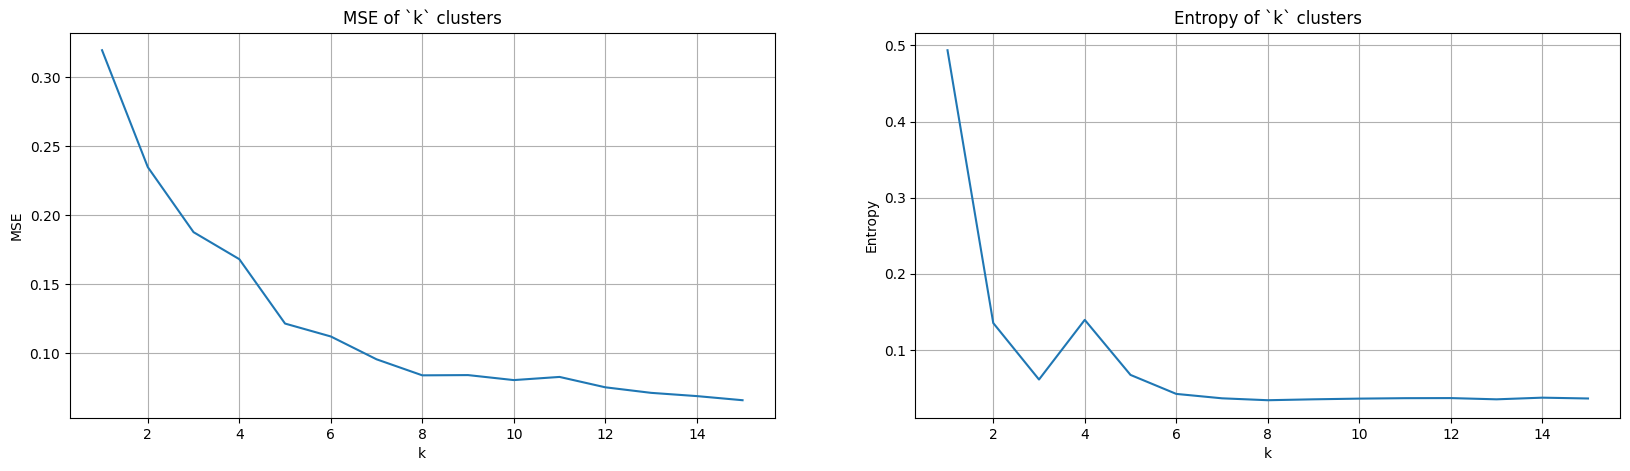

In [33]:
def plot_clustering_metrics(metrics_dict, fig_size=(20, 5)):
    """ Plot clustering metrics for different number of clusters. """
    # Number of metrics to plot
    n_metrics = len(metrics_dict)
    # Create plot for metrics
    fig = plt.figure(figsize=fig_size)

    for i, (metric_name, data) in enumerate(metrics_dict.items()):
        ax = fig.add_subplot(1, n_metrics, i+1)
        # Plot current metric on sub-plot
        ax.plot(np.arange(1, len(data)+1, dtype=int), data)

        # Title
        ax.set_title(f"{metric_name} of `k` clusters")
        # Axis labels
        ax.set_xlabel("k")
        ax.set_ylabel(metric_name)
        # Show grid
        ax.grid()

    # Show figure
    print(fig)

# Plot K-means MSE and clustering entropy
plot_clustering_metrics({
    "MSE": k_means_mse,
    "Entropy": k_means_entropy
})

The MSE plot does not show us anything useful, because MSE constantly decreases as the number of clusters increases. The overall entropy plot, on the other hand, gives us insights as we find $k = 4$ to be the local minimum of overall clustering entropy. This proves that partitioning samples into 4 clusters is a reasonable choice.

### Gaussian Mixture (Distribution-based Clustering)

Another popular clustering algorithm is Gaussian Mixture (GM) clustering, which utiltize **Gaussian mixture models**. A Gaussian mixture model is a mixture probability distribution consisting of several Gaussian distributions, each parameterized by mean $\mathbf{\mu}_i$ and variance $\mathbf{\Sigma}_i$. During training, we fit the Gaussian mixture model, such that its mixture proabability distribution matches the actual distribution of samples. This is done by iteratively performing **Expectation-Maximization (EM)**, which is somewhat similar to K-means:

* Expectation step (E step): compute the expected log likelihood of samples under the current mixture distribution.
* Maximization step (M step): maximize the expected log likelihood by adjusting distribution parameters.

When the EM algorithm converges, we compute the probability of all samples under each component Gaussian distribution. Then, the clustering category of a sample is determined by finding the Gaussian distribution under which the probability of the sample is the greatest.

In the following code cell, we run Gaussian Mixture clustering on raw `StandardScaler` features and t-SNE transformed `StandardScaler` features. We will set the number of clusters to 5. Again, we compute the confusion matrix for both clustering results, then visualize the clustering using for t-SNE transformed features:

Gaussian Mixture (Raw features) started...
Gaussian Mixture (Raw features) completed. Elapsed time: 1.26s

Gaussian Mixture (t-SNE) started...
Gaussian Mixture (t-SNE) completed. Elapsed time: 1.40s

Gaussian Mixture (t-SNE) started...
Gaussian Mixture (t-SNE) completed. Elapsed time: 1.43s

Confusion matrix of Gaussian Mixture on raw features:
 [[    2 13988]
 [    0  4353]
 [  271     0]
 [ 4476   199]
 [    2  1048]] 

Confusion matrix of Gaussian Mixture on autoencoder (AE-1) transformed features:
 [[    1 13978]
 [    0  4231]
 [ 1564   208]
 [    0  1000]
 [ 2787     0]
 [  399   171]] 

Confusion matrix of Gaussian Mixture on enhanced autoencoder (AE-2) transformed features:
 [[    1 13855]
 [ 1245   149]
 [  102  1004]
 [    0  4280]
 [ 2542     6]
 [  861   294]] 

Figure(1000x500)
Figure(1000x500)


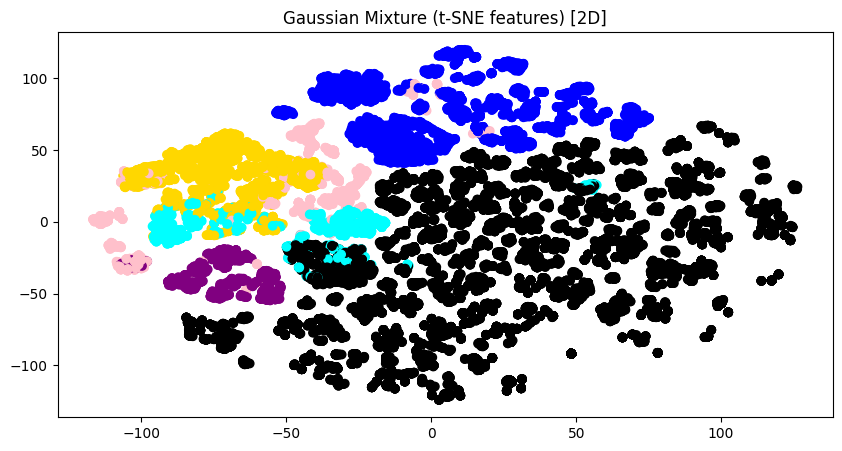

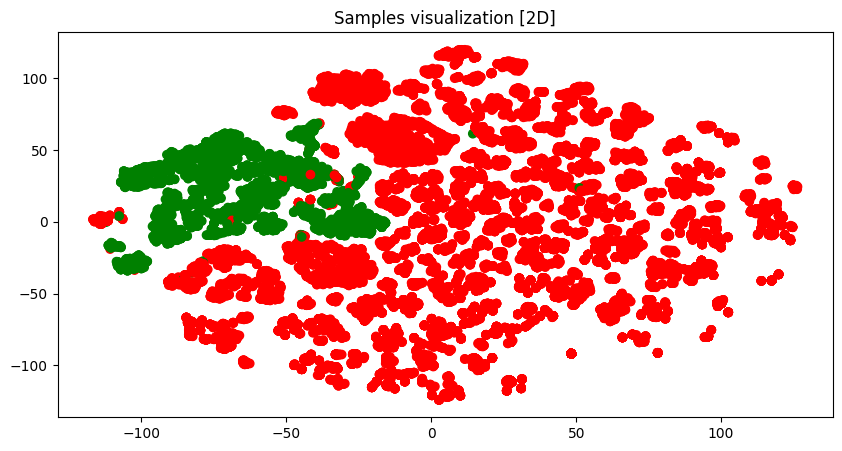

In [34]:
from sklearn.mixture import GaussianMixture

# Gaussian mixture clustering on raw `StandardScaler` features
# (Learn 4 clusters for all samples)
gm_std = GaussianMixture(n_components=5, random_state=87654321)
with timeit("Gaussian Mixture (Raw features)"):
    pred_gm_std = gm_std.fit_predict(kdd_feat_std)

print("")
# Gaussian mixture on autoencoder transformed `StandardScaler` features
gm_autoenc1 = GaussianMixture(n_components=6, random_state=87654321)
with timeit("Gaussian Mixture (t-SNE)"):
    pred_gm_autoenc1 = gm_autoenc1.fit_predict(kdd_feat_ae_1)

print("")

# Gaussian mixture on enhanced autoencoder transformed `StandardScaler` features
gm_autoenc2 = GaussianMixture(n_components=6, random_state=87654321)
with timeit("Gaussian Mixture (t-SNE)"):
    pred_gm_autoenc2 = gm_autoenc2.fit_predict(kdd_feat_ae_2)

print("")

# Confusion matrix of clustering results
print(
    "Confusion matrix of Gaussian Mixture on raw features:\n",
    confusion_matrix(y_std, pred_gm_std), "\n"
)
print(
    "Confusion matrix of Gaussian Mixture on autoencoder (AE-1) transformed features:\n",
    confusion_matrix(y_std, pred_gm_autoenc1), "\n"
)
print(
    "Confusion matrix of Gaussian Mixture on enhanced autoencoder (AE-2) transformed features:\n",
    confusion_matrix(y_std, pred_gm_autoenc2), "\n"
)

# Plot K-means clustering result for t-SNE transformed features
visualize_samples(
    kdd_feat_ae_2_tsne, pred_gm_autoenc2,
    title="Gaussian Mixture (t-SNE features)",
    colors=["black", "cyan", "purple", "blue", "gold","pink"]
)
visualize_samples(kdd_feat_ae_2_tsne, y_std)

Like K-means, we are interested in the best choice of number of clusters, so we compute and plot the overall clustering entropy for different number of clusters using the Gaussian Mixture clustering:

Running Gaussian Mixture for k = 5...
Running Gaussian Mixture for k = 10...
Running Gaussian Mixture for k = 15...
Figure(600x400)


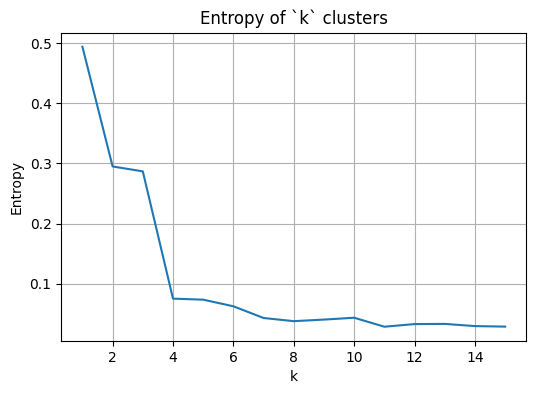

In [35]:
# Overall entropy for each `k` value
gm_entropy = []

# Maximal number of clusters to try
k_max = 15

for k in range(1, k_max+1):
    if k%5==0:
        print(f"Running Gaussian Mixture for k = {k}...")

    # Learn `k` clusters during gaussian mixture clustering
    gm_t_autoenc_try = GaussianMixture(n_components=k, random_state=87654321)
    # Cluster t-SNE transformed `StandardScaler` features
    pred_gm_autoenc_try = gm_t_autoenc_try.fit_predict(kdd_feat_ae_2)

    # Compute and store clustering entropy for `k`
    entropy_k = clustering_entropy(confusion_matrix(y_std, pred_gm_autoenc_try))
    gm_entropy.append(entropy_k)

# Plot overall clustering entropy for GM clustering results
plot_clustering_metrics({"Entropy": gm_entropy}, fig_size=(6, 4))

# 📝 Discussion Questions (Answer in this notebook)

> **Q1 (AE-2 + K-means): Choosing the number of clusters**  
> Using your **Entropy vs. k** plot for **K-means** on **AE-2 features**, justify the number of clusters **we chose** for AE-2.  
> In your justification, clearly refer to what you see in the plot.


Looking at the Entropy vs. k plot for K-means on AE-2 features, the overall clustering entropy shows a local minimum around k=4. Entropy measures the impurity of the clusters with respect to the true labels. A lower entropy indicates purer clustering, meaning that samples within each cluster are more likely to belong to a single true class. While the Mean Squared Error MSE continuously decreases as k increases, the entropy plot provides a more informative criterion for selecting the optimal number of clusters when true labels are available Therefore, k=4 was chosen because it represents a point where the clustering achieves a relatively high level of purity, as indicated by the local minimum in the entropy curve, before potentially over-splitting the data into too many less distinct clusters.




> **Q2 (K-means): Best feature extraction method**  
> Using the **confusion matrices** you computed for **K-means**, decide which feature extraction method gives the best clustering results:  
> - raw standardized features (`kdd_feat_std`)  
> - AE-1 bottleneck features (`kdd_feat_ae_1`)  
> - AE-2 bottleneck features (`kdd_feat_ae_2`)  
> Explain your choice using specific patterns you observe in the confusion matrices.

Among the three feature extraction methods for K-means clustering, the AE-2 bottleneck features yield the best clustering results. This is evident from their confusion matrix, which shows significantly higher purity in clusters compared to both the raw standardized features and the AE-1 bottleneck features. For instance, with raw features, clusters often contain a heavy mix of both normal and attack samples, indicating poor separation. While AE-1 shows some improvement, AE-2 demonstrates even more distinct clusters, with many being almost exclusively composed of either normal or attack samples, signifying superior feature representation for K-means.



> **Q3 (AE-2 + Gaussian Mixture): Choosing the number of clusters**  
> Using your **Entropy vs. k** plot for **Gaussian Mixture** on **AE-2 features**, justify the number of clusters **we chose** for AE-2.  
> Refer to what you see in the plot.


Based on the Entropy vs. k plot for Gaussian Mixture on AE-2 features, the choice of k=6 for the number of clusters can be justified by observing the trend in the overall clustering entropy. The plot shows a sharp decrease in entropy as k increases from 1, indicating that adding more clusters initially leads to much 'purer' groupings. After k=4, the entropy continues to decrease significantly, reaching a value of approximately 0.0625 at k=6. While the entropy continues to slightly decrease further for k=7 and k=8, reaching a minimum around k=11, k=6 represents a point where a substantial reduction in entropy has been achieved, making it a reasonable choice that balances cluster purity with model complexity, before the improvements become marginal or the entropy starts fluctuating.




> **Q4 (Gaussian Mixture): Best feature extraction method**  
> Using the **confusion matrices** you computed for **Gaussian Mixture**, decide which feature extraction method gives the best clustering results:  
> - raw standardized features (`kdd_feat_std`)  
> - AE-1 bottleneck features (`kdd_feat_ae_1`)  
> - AE-2 bottleneck features (`kdd_feat_ae_2`)  
> Explain your choice using specific evidence from the confusion matrices.

Among the three feature extraction methods for Gaussian Mixture clustering, the AE-1 bottleneck features provide the best clustering results. This is evident from its confusion matrix, which shows the most consistent creation of highly pure clusters, meaning samples within each cluster predominantly belong to a single true class. While raw standardized features and AE-2 bottleneck features also produce some pure clusters, they exhibit a higher degree of mixing in other clusters. The AE-1 features, therefore, demonstrate a better ability to represent the data in a way that allows the Gaussian Mixture model to effectively separate the normal and attack instances with greater purity across the resulting clusters.

## References

1. KDD Cup 1999 Dataset: https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
2. Autoencoder: https://en.wikipedia.org/wiki/Autoencoder
3. K-means clustering: https://en.wikipedia.org/wiki/K-means_clustering
4. Lloyd's algorithm: https://en.wikipedia.org/wiki/Lloyd%27s_algorithm
5. K-means++: https://en.wikipedia.org/wiki/K-means%2B%2B
6. Mixture model: https://en.wikipedia.org/wiki/Mixture_model
7. Expectation-Maximization (EM): https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm